In [1]:
# Readlines example
train_file_path = 'zscore/training/Train_Dst_NoAuction_ZScore_CF_7.txt'
horizon_k = [10, 20, 50, 100]
alpha = 0.001
# using numpy loadtext
import numpy as np
data = np.loadtxt(train_file_path)
print(data.shape)

(149, 254750)


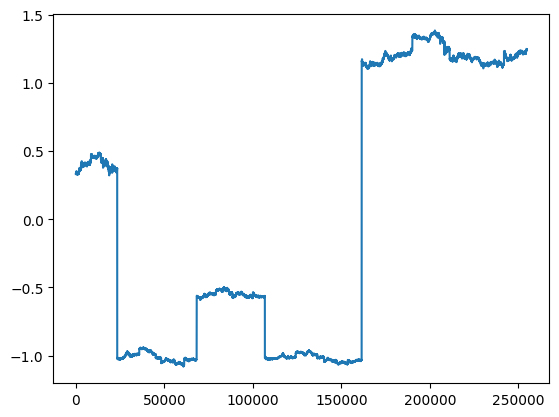

In [2]:
# draw a line chart for the first price
import matplotlib.pyplot as plt
first_price = data[0,:]
plt.plot(first_price)
plt.show()


In [3]:
# detect the jump point in data
threshold = 0.2
jump_points = [i for i in range(1, len(first_price)) if abs(first_price[i-1] - first_price[i]) > threshold]
print(jump_points)

[23336, 68210, 106759, 161434]


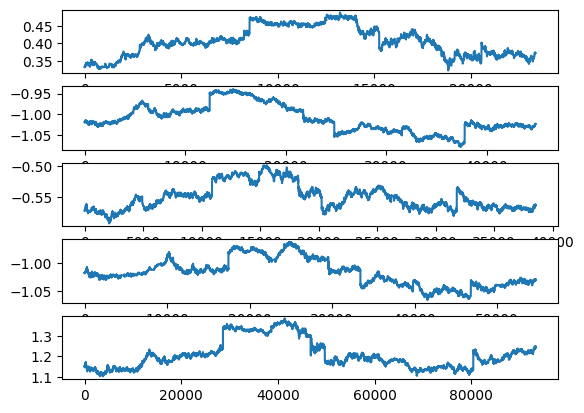

In [4]:
# subplot five series
fig, axs = plt.subplots(5, 1)
left_bound = 0
series_list = []
for i in range(5):
    right_bound = jump_points[i] if i <= 3 else len(first_price)
    stock_data = data[:, left_bound:right_bound]
    series_list.append(stock_data[:40,:])
    axs[i].plot(stock_data[0,:])
    left_bound = right_bound
plt.show()
plt.close()

In [7]:
def draw_bar_chart(series):
    num_fall = len(series[series == '-1'])
    num_stay = len(series[series == '0'])
    num_rise = len(series[series == '1'])

    plt.bar(['-1', '0', '1'], [num_fall, num_stay, num_rise], width = 0.4)
    plt.show()
    plt.close()

def draw_segmented_line_chart(df_pt_label, k):
    import seaborn as sns
    import pandas as pd

    fig, ax1 = plt.subplots(figsize=(12, 4))
    df_pt_label = df_pt_label[:2000]
    
    palette ={"-1": "#2ca02c", "0": "#ffffff", "1": "#d62728"}
    ax1.plot(list(range(len(df_pt_label))), df_pt_label['mid_price'] + -1*df_pt_label['mid_price'].min(), label="mid_prices", color='blue', linewidth=1)
    sns.barplot(x=list(range(len(df_pt_label))), y=[(df_pt_label['mid_price'] + -1*df_pt_label['mid_price'].min()).max()] * len(df_pt_label),
            hue='label_'+str(k), alpha=0.5, palette=palette, dodge=False, data=df_pt_label, ax=ax1).set(xticklabels=[]) #
    for bar in ax1.patches: # optionally set the bars to fill the complete background, default seaborn sets the width to about 80%
        bar.set_width(1)
    
    plt.show()
    plt.close()

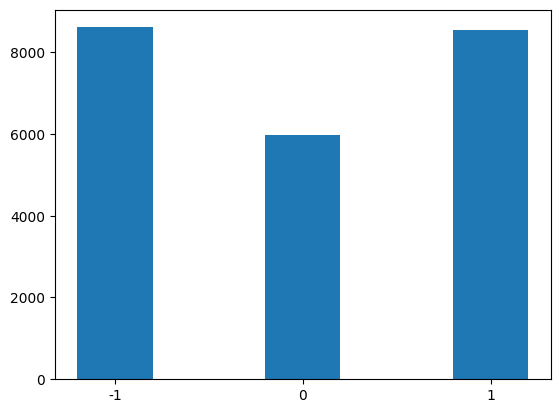

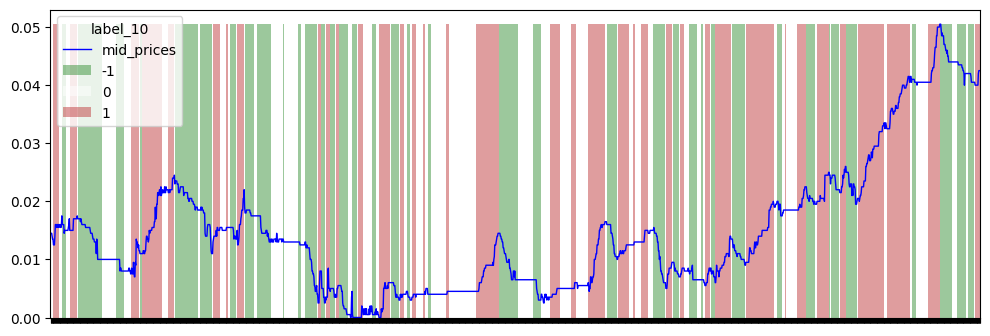

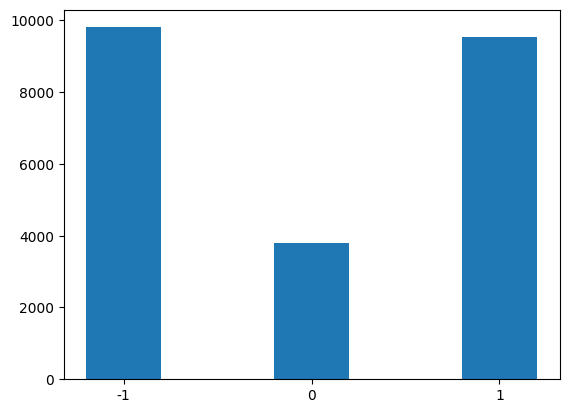

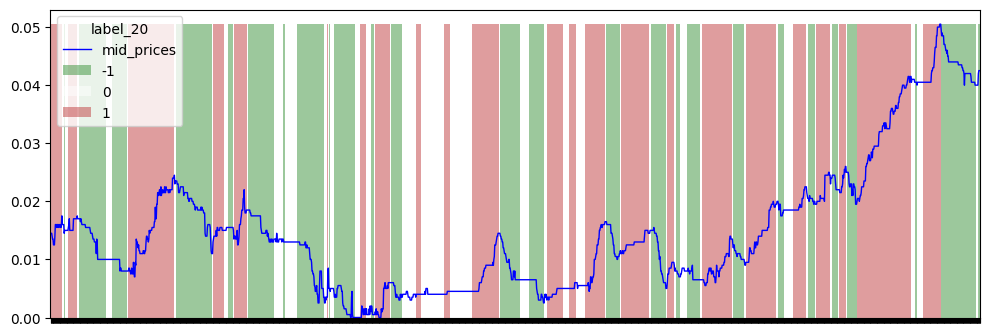

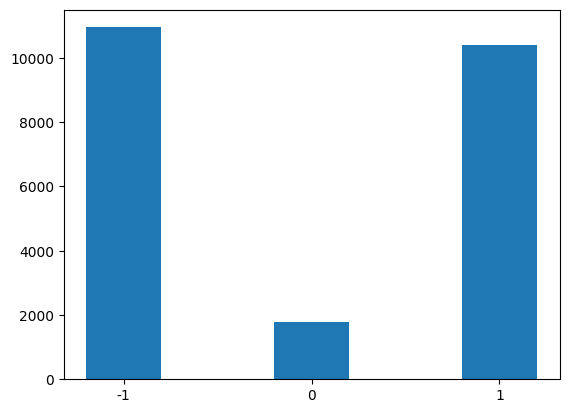

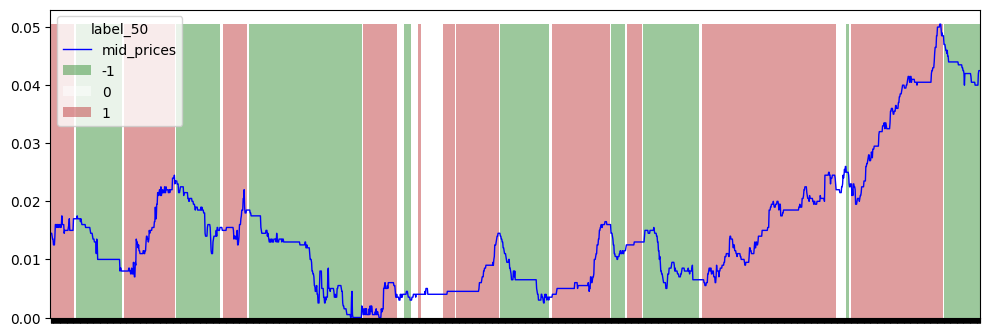

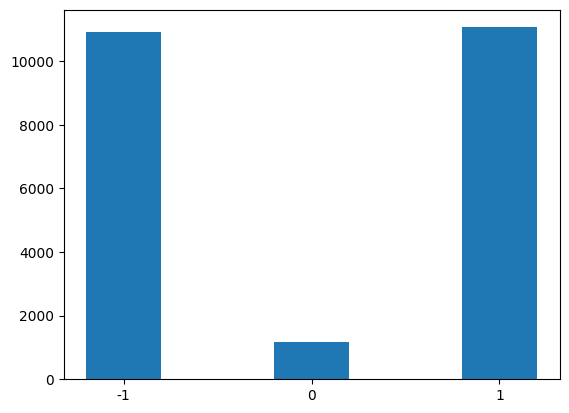

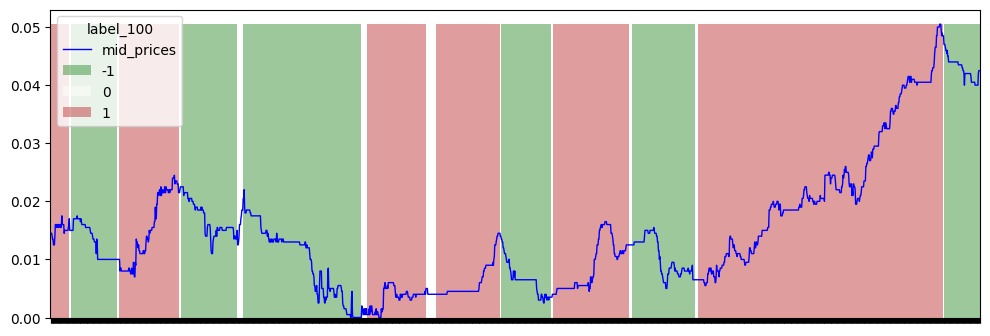

In [8]:
# labeling
# smoothing the data
import pandas as pd

for s in series_list[0:1]:
    temp_df = pd.DataFrame()
    temp_df['mid_price'] = (s[0,:] + s[2,:])/2
    for k in horizon_k:
        temp_df['mm_'+str(k)] = temp_df['mid_price']  # mean of previous k ticks
        temp_df['mp_'+str(k)] = temp_df['mid_price']  # mean of next k ticks 
        for r in range(k):
            temp_df['mm_'+str(k)] += temp_df['mid_price'].shift(periods=(r+1)).fillna(0)
            temp_df['mp_'+str(k)] += temp_df['mid_price'].shift(periods=-1*(r+1)).fillna(0)

        temp_df['mm_'+str(k)] = temp_df['mm_'+str(k)]/k
        temp_df['mp_'+str(k)] = temp_df['mp_'+str(k)]/k
    
    temp_df = temp_df[max(horizon_k):-1*max(horizon_k)]
    ranges = [-10**6, -1*alpha, alpha, 10**6 ]  # alpha = 0.001

    for k in horizon_k:
        lt_k = (temp_df['mp_'+str(k)] - temp_df['mm_'+str(k)])/temp_df['mm_'+str(k)].abs()
        temp_df['label_'+str(k)] = pd.cut(lt_k, ranges, right = False, labels = ['-1', '0', '1'])
        draw_bar_chart(temp_df['label_'+str(k)])
        draw_segmented_line_chart(temp_df[['mid_price', 'label_'+str(k)]], k)
